In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def process_features(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    cols = ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']
    for col in cols:
        df = create_dummies(df, col)
    return df

In [3]:
train = process_features(train)
holdout = process_features(holdout)

In [4]:
print(train[['SibSp', 'Parch']].dtypes)
train.drop("Survived",axis=1)[['SibSp', 'Parch']].plot.hist(alpha=0.5)

SibSp    int64
Parch    int64
dtype: object


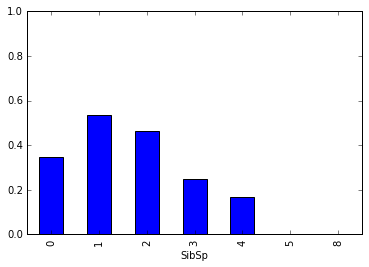

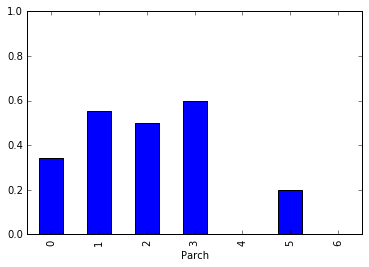

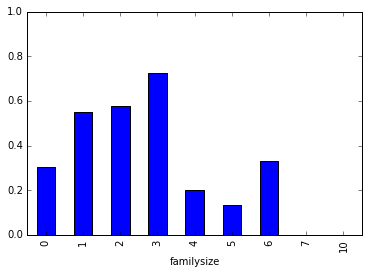

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

cols = ['SibSp', 'Parch']
for col in cols:
    pivot_table = train.pivot_table(index=col, values='Survived')
    pivot_table.plot.bar(ylim=(0,1))
    plt.show()
    
train['familysize'] = train[["SibSp","Parch"]].sum(axis=1)
holdout['familysize'] = holdout[["SibSp","Parch"]].sum(axis=1)
pivot_table = train.pivot_table(index=['familysize'], values='Survived')
pivot_table.plot.bar(ylim=(0,1))
plt.show()

The survival rate for passengers with 1 to 3 family members on board was higher when compared with bigger families or with passengers with no family.

In [6]:
def is_alone(df):
    alone = df[df['familysize'] == 0].index
    df['isalone'] = 0
    df.loc[alone, 'isalone'] = 1
    df = df.drop("familysize",axis=1)
    return df

In [7]:
train = is_alone(train)
holdout = is_alone(holdout)

In [8]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    # print(df.shape)
    df = df.select_dtypes([np.number]).dropna(axis='columns', how='any')
    # print(df.shape)
    features = df.columns.drop(['PassengerId', 'Survived'])
    # print(features)
    all_X = df[features]
    all_y = df['Survived']
    
    rfc = RandomForestClassifier(random_state=1)
    selector = RFECV(rfc, cv=10)
    selector.fit(all_X, all_y)
    
    print(list(features))
    print(list(features[selector.support_]))
    
    return list(features[selector.support_])

best_features = select_features(train)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    
    models = [
        {
            'name': 'LogisticRegression',
            'estimator': LogisticRegression(),
            'hyperparameters': 
                {
                    'solver': ['newton-cg', 'lbfgs', 'liblinear']
                }
        },
        {
            'name': 'KNeighborsClassifier',
            'estimator': KNeighborsClassifier(),
            'hyperparameters':
                {
                    'n_neighbors': range(1,20,2),
                    'weights': ['distance', 'uniform'],
                    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                    'p': [1,2]
                }
        },
        {
            'name': 'RandomForestClassifier',
            'estimator': RandomForestClassifier(),
            'hyperparameters':
                {
                    'n_estimators': [4,6,9],
                    'criterion': ['entropy', 'gini'],
                    'max_depth': [2,5,10],
                    'max_features': ['log2', 'sqrt'],
                    'min_samples_leaf': [1,5,8],
                    'min_samples_split': [2,3,5]
                }
        }
    ]
    
    for model in models:
        print(model['name'])
        clf = GridSearchCV(model['estimator'], model['hyperparameters'])
        clf.fit(all_X, all_y)
        
        model['best_parameters'] = clf.best_params_
        model['best_score'] = clf.best_score_
        model['best_estimator'] = clf.best_estimator_
        
        print(model['best_parameters'])
        print(model['best_score'])
        
    return models

models = select_model(train, best_features)

LogisticRegression
{'solver': 'liblinear'}
0.817059483726
KNeighborsClassifier
{'n_neighbors': 15, 'weights': 'distance', 'algorithm': 'brute', 'p': 1}
0.760942760943
RandomForestClassifier
{'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'entropy', 'n_estimators': 6, 'max_features': 'sqrt'}
0.83950617284


In [18]:
def save_submission_file(trained_model, features, filename='submission.csv'):
    predictions = trained_model.predict(holdout[features])
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename, sep=',', index=False)

In [14]:
best_model = select_model(train, best_features)[2]['best_estimator']

LogisticRegression
{'solver': 'liblinear'}
0.817059483726
KNeighborsClassifier
{'n_neighbors': 15, 'weights': 'distance', 'algorithm': 'brute', 'p': 1}
0.760942760943
RandomForestClassifier
{'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'entropy', 'n_estimators': 9, 'max_features': 'log2'}
0.838383838384


In [19]:
save_submission_file(best_model, best_features)